# Trabajo Final de Métodos Estadísticos Avanzados en Ciencia de los Datos

## Autor: Juan Camilo Saldarriaga (solo)
## Cc: 1026146059

### Paquetes necesarios:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt
import statsmodels.api as sm

# Introducción 

El objetivo de este análisis es caracterizar las relaciones entre algunos indicadores macroeconómicos y los costos y gastos de ventas de las empresas colombianas vigiladas por la SuperSociedades.

Este análisis se hace con datos de periodicidad Anual, debido a que es la periodicidad que maneja la Superintendencia de Sociedades. Para el análisis a nivel de sector económico, se busca identificar un sector en particular usando la categoría CIIU (Clasificación Industrial Internacional Uniforme), que tuviera por lo menos 20 empresas registradas en la SuperSociedades.

Los resultados de este análisis están incluidos en un repositorio de GitHub, el cual esta públicamente accesible en el siguiente enlace:

https://github.com/juancsaldarriaga/Informe_sector_consultoria_MAE

Para la descarga de datos lo que hice fue que consulte diferentes en bases de datos oficiales como: 

- Datos abiertos del gobierno nacional (www.datos.gov.co)
- DANE (https://www.dane.gov.co/index.php/estadisticas-por-tema)
- Banco Mundial (https://datos.bancomundial.org/)
- Cepal (https://estadisticas.cepal.org/cepalstat/WEB_CEPALSTAT/estadisticasIndicadores.asp?idioma=e), 
- Banco de la Republica (https://www.banrep.gov.co/es/catalogo-estadisticas-disponibles). 

Fue difícil ubicar algunos de los archivos debido a que las fuentes oficiales pueden tener enlaces caídos y rotos. Por este motivo, se hizo necesario buscar agencias internacionales de estadísticas que recopilan información macroeconómica para varios países, como la Cepal y el Banco Mundial.

# Datos
## Información de Sociedades

Para adquirir la información de las empresas registradas en la Superintendencia de Sociedades, fue necesario recurrir a una fuente diferente a la sugerida por el profesor, debido a que dichos enlaces nunca estuvieron disponibles. Pero, aun así, se descubrió que en la página web de datos abiertos del gobierno nacional, tenían un repositorio con una copia de la información de la SuperSociedades. Se debían descargar diferentes archivos para cada año y a continuación se listan los archivos por año:

 ### Los archivos correspondientes al 2017 son:
- 'NIIF_Plenas_Individuales_05_06_2018.xls'
- 'NIIF_Pymes_Individuales_05_06_2018.xls'

### Los archivos correspondientes al 2018 son:
- 'NIIF Plenas Individuales.xlsx'
- 'NIIF Plenas Separados.xlsx'
- 'NIIF Pymes Individuales.xlsx'
- 'NIIF Pymes Separados.xlsx'
 
### Los archivos correspondientes al 2019 son:
- 'Plenas-Individuales.xlsx'
- 'Plenas-Separados.xlsx'
- 'Pymes-Individuales.xlsx'
- 'Pymes-Separados.xlsx'

Se decide usar solo los archivos que dicen "Individuales", porque los que dicen "Separados" no están disponibles para el año 2018. Adicionalmente, se decide usar la información que dice "Plenas" diferentes a las que dicen "Pymes", con la idea de que las Plenas pueden ser empresas más grandes, que estén más consolidadas y con una alta posibilidad de tener buena disponibilidad de datos.

In [2]:
pd.read_excel("../trabajo_final/datos/Plenas-Individuales.xlsx", 
              None).keys()

dict_keys(['Carátula', 'ESF', 'ERI', 'ORI', 'EFE'])

In [3]:
caratula = pd.read_excel("../trabajo_final/datos/NIIF_Plenas_Individuales_05_06_2018.xls", 
                         "Caratula") #'Carátula'

In [4]:
ERI = pd.read_excel("../trabajo_final/datos/NIIF_Plenas_Individuales_05_06_2018.xls",
                    'Estado de Resultados Integrales')# ERI

A continuación, se muestra la lista de los sectores registrados en la base de datos que tienen por lo menos 20 empresas registradas:

In [5]:
caratula['Clasificación Industrial Internacional Uniforme Versión 4 A.C'].value_counts()[:30]

L6810 - Actividades inmobiliarias realizadas con bienes propios o arrendados                                                                                            105
F4111 - Construcción de edificios residenciales                                                                                                                          92
A0125 - Cultivo de flor de corte                                                                                                                                         74
G4659 - Comercio al por mayor de otros tipos de maquinaria y equipo n.c.p.                                                                                               66
G4645 - Comercio al por mayor de productos farmacéuticos, medicinales, cosméticos y de tocador                                                                           57
C2229 - Fabricación de artículos de plástico n.c.p.                                                                                         

Utilizando esta información, se escoge trabajar el sector J6202: "Actividades de consultoría informática y actividades de administración de instalaciones informáticas", el cual es un sector que tiene registradas 31 empresas.

Se cargan individualmente cada uno de los archivos de la Superintendencia de Sociedades, porque tienen diferencias en los formatos de como nombran las variables y los archivos de un año a otro (no están estandarizados).

# 2017

In [6]:
ERI = pd.read_excel("../trabajo_final/datos/NIIF_Plenas_Individuales_05_06_2018.xls", 
                    'Estado de Resultados Integrales')
caratula = pd.read_excel("../trabajo_final/datos/NIIF_Plenas_Individuales_05_06_2018.xls", 
                         'Caratula')

In [7]:
ERI = ERI[ERI["PERIODO"] == "2017"]

In [8]:
codigos_interes =  caratula[caratula['Clasificación Industrial Internacional Uniforme Versión 4 A.C'] == 
"J6202 - Actividades de consultoría informática y actividades de administración de instalaciones informáticas"][
    "Nit"].to_list()
print("NITs para 2017:", codigos_interes)

NITs para 2017: [830055791, 900387076, 800110980, 900218578, 830114969, 900032774, 900478383, 900150662, 830006265, 800057965, 800066453, 800103052, 800241958, 900601546, 830089336, 830103650, 830042244, 900583745, 800159527, 830110433, 900210032, 860002433, 900079131, 900555829, 900478030, 900258336, 805025216, 900420814, 900091709, 830135305, 900773345]


In [9]:
reindex = []
for i in codigos_interes:
    reindex = reindex+ ERI[ERI['NIT'] == i].index.to_list()

In [10]:
ERI.loc[:, "Otros gastos"] = ERI.loc[:, "Otros gastos, por función"]

In [11]:
DF_consolidad = ERI.loc[reindex][["NIT", "Costo de ventas", "Gastos de administración","Otros gastos", "PERIODO"]]

# 2018

In [12]:
ERI = pd.read_excel("../trabajo_final/datos/NIIF Plenas Individuales.xlsx", 'ERI')# Estado de Resultados Integrales
caratula = pd.read_excel("../trabajo_final/datos/NIIF Plenas Individuales.xlsx", "Caratula") #'Caratula'

In [13]:
ERI = ERI[ERI["Periodo"] == "Periodo Actual"]

In [14]:
codigos_interes =  caratula[caratula['Clasificación Industrial Internacional Uniforme Versión 4 A.C'] == 
"J6202 - Actividades de consultoría informática y actividades de administración de instalaciones informáticas"][
    "Nit"].to_list()
print("NITs para 2018:", codigos_interes)

NITs para 2018: [800057965, 830135305, 900091709, 830110433, 830089336, 800159527, 900555829, 900478030, 830042244, 900079131, 900210032, 800103052, 900583745, 800066453, 900773345, 900601546, 830103650, 830006265, 800241958, 900150662, 830114969, 900032774, 900387076, 800110980, 900478383, 830055791]


In [15]:
reindex = []
for i in codigos_interes:
    reindex = reindex+ ERI[ERI['Nit'] == i].index.to_list()

In [16]:
ERI.loc[:, "PERIODO"] = "2018"
ERI.loc[:, "NIT"] = ERI.loc[:, "Nit"]

In [17]:
DF_consolidad = DF_consolidad.append(ERI.loc[reindex][["NIT", "Costo de ventas", "Gastos de administración", 
                                                       "Otros gastos","PERIODO"]], ignore_index = True)

# 2019

In [18]:
ERI = pd.read_excel("../trabajo_final/datos/Plenas-Individuales.xlsx", 'ERI')# Estado de Resultados Integrales
caratula = pd.read_excel("../trabajo_final/datos/Plenas-Individuales.xlsx", "Carátula") #'Caratula'

In [19]:
ERI = ERI[ERI["Periodo"] == "Periodo Actual"]

In [20]:
codigos_interes =  caratula[caratula['Clasificación Industrial Internacional Uniforme Versión 4 A.C'] == 
"J6202 - Actividades de consultoría informática y actividades de administración de instalaciones informáticas"][
    "Nit"].to_list()
print("NITs para 2019:", codigos_interes)

NITs para 2019: [900129331.0, 900555829.0, 800066453.0, 900103457.0, 900091709.0, 900601546.0, 830089336.0, 900210032.0, 800057965.0, 800159527.0, 900912034.0, 900079131.0, 830110433.0, 900266595.0, 900773345.0, 830103650.0, 900478030.0, 860002433.0, 900387076.0, 900583745.0, 830042244.0, 900150662.0, 800241958.0, 830006265.0, 830114969.0, 900478383.0, 830055791.0, 800103052.0]


In [21]:
reindex = []
for i in codigos_interes:
    reindex = reindex+ ERI[ERI['Nit'] == i].index.to_list()

In [22]:
ERI.loc[:, "PERIODO"] = "2019"
ERI.loc[:, "NIT"] = ERI.loc[:, "Nit"]

In [23]:
DF_consolidad = DF_consolidad.append(ERI.loc[reindex][["NIT", "Costo de ventas", "Gastos de administración", 
                                                       "Otros gastos","PERIODO"]], ignore_index = True)

### Consolidado con los 3 años

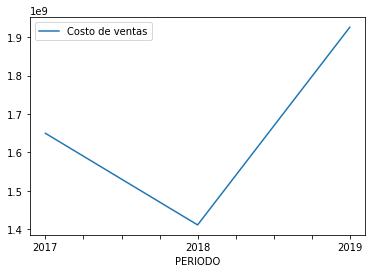

In [24]:
DF_consolidad.pivot_table("Costo de ventas", "PERIODO", None, "sum").plot()

In [25]:
DF_consolidad.loc[:, "PERIODO"] = DF_consolidad.loc[:, "PERIODO"].astype(int)

In [26]:
DF_consolidad.loc[:,"gastos totales"]=DF_consolidad[["Gastos de administración","Otros gastos"]].sum(axis=1)

In [27]:
DF_consolidad

,NIT,Costo de ventas,Gastos de administración,Otros gastos,PERIODO,gastos totales
0,830055791,111785644.0,8687418.0,12444437.0,2017,21131855.0
1,900387076,42844825.0,8519181.0,40807.0,2017,8559988.0
2,800110980,NaN,70703148.0,130162423.0,2017,200865571.0
3,900218578,96108899.0,30827079.0,1083.0,2017,30828162.0
4,830114969,29554834.0,5630907.0,188296.0,2017,5819203.0
...,...,...,...,...,...,...
80,830006265,1645195.0,2655185.0,3769716.0,2019,6424901.0
81,830114969,30275906.0,6405229.0,NaN,2019,6405229.0
82,900478383,174043944.0,11817410.0,993332.0,2019,12810742.0
83,830055791,92144237.0,11458156.0,167598.0,2019,11625754.0


# Variables Macroeconómicas 

- PIB
- Tasa de Cambio-TRM 
- Desempleo
- Inflación
- Costos de ventas
- Gastos de ventas

# PIB

La información de Producto Interno Bruto, se descarga del DANE, con información a precios constantes de 2015, y ya viene de una vez anual.

In [28]:
PIB = pd.read_excel("../trabajo_final/datos/pib_desestacionalizado_2015_020.xls", skiprows=7)

In [29]:
PIB = PIB.rename(columns={'Unnamed: 0': "Periodo", 'Unnamed: 4': "PIB_en_pesos_de_2015"})

In [30]:
PIB.loc[13, 'Periodo'] = 2018
PIB.loc[14, 'Periodo'] = 2019

In [31]:
PIB = PIB[['Periodo', 'PIB_en_pesos_de_2015']][:15].set_index('Periodo').astype(int)

In [32]:
PIB.index

Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017, 2018, 2019],
           dtype='int64', name='Periodo')

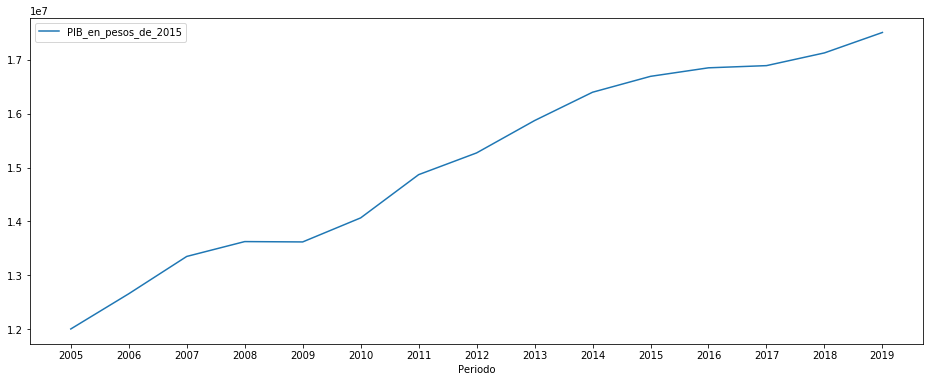

In [33]:
PIB.plot(figsize=(16,6), xticks=range(2005,2020))

# Desempleo

La información de la Tasa de Desempleo, se descarga del DANE, la información viene desagregada a nivel mensual, y el formato que maneja el DANE es complicado al momento de leer el archivo con código. Se genera una serie que contiene los diferentes años, y se agrega utilizando el valor promedio de la tasa mensual de desempleo para cada año.

In [34]:
pd.read_excel("../trabajo_final/datos/anexo_desestacionalizado_empleo_ago_20.xlsx", None).keys()

dict_keys(['Indice', 'Tnal mensual', '13 áreas mensual', 'tnal cabe ru trim movil', 'areas trim movil'])

In [35]:
desempleo=pd.read_excel("../trabajo_final/datos/anexo_desestacionalizado_empleo_ago_20.xlsx", "Tnal mensual", 
                        skiprows=11)#, header=None)#, header=3)#, header=[0,1])#.set_index("Unnamed: 0_level_1")
desempleo = desempleo.set_index("Concepto").T#.reset_index()

In [36]:
a = []
for i in range(2001,2021):a= a+(12*[i])#+12*[2012]

In [37]:
desempleo = desempleo.set_index(pd.Series(a[:-4]))

In [38]:
desempleo = desempleo.reset_index().pivot_table("TD", "index", None, "sum")/12 # El 2020 no estaria bien porque solo hay 8 meses
#desempleo.index

In [39]:
desempleo.index.name="Periodo"

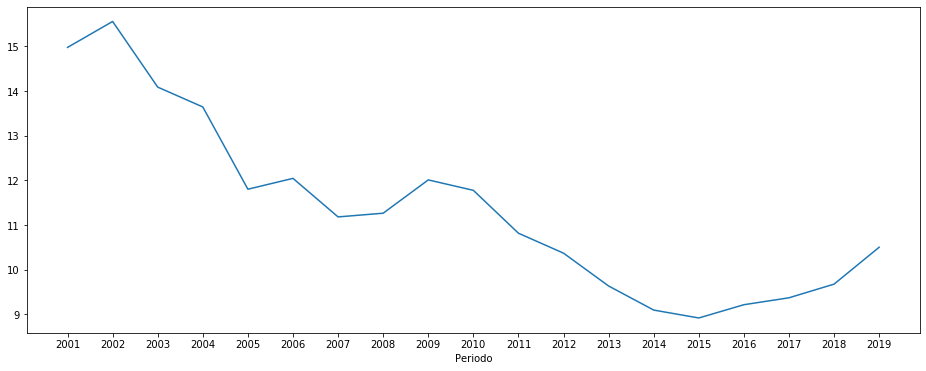

In [40]:
desempleo.loc[range(2001,2020),"TD"].plot(figsize=(16,6), xticks=range(2001,2020))
#plt.xbins=range(2001,2020)

# Inflación

La información de la inflación, se descarga del DANE, la cual ya viene calculada como la variación del Índice de Precios al Consumidor (IPC). La información la suministran tanto con periodicidad mensual, como con periodicidad anual, yo de una vez utilizo la anual.

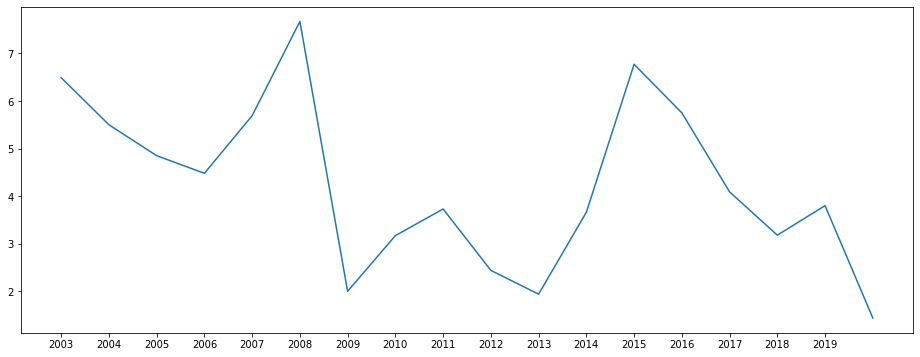

In [41]:
inflacion = pd.read_excel("../trabajo_final/datos/IPC_Variacion.xlsx", 'VarNal', skiprows=6
                         ).set_index("Mes").loc["En año corrido"]
inflacion.plot(figsize=(16,6), xticks=range(2003,2020))

# TRM

La información de la Tasa de Cambio Representativa del Mercado- TRM, fue descargada de la página de datos abiertos del gobierno nacional. Esta información viene con una periodicidad diaria, para los días que funcionan los mercados financieros. De nuevo, se hizo un promedio de la variable para cada año, en este caso la TRM, y esa es la que se usa en el modelado.

In [42]:
TRM = pd.read_csv("../trabajo_final/datos/Tasa_de_Cambio_Representativa_del_Mercado-_TRM.csv")

In [43]:
TRM.loc[:, "Periodo"] = TRM["VIGENCIADESDE"].astype('datetime64[ns]').dt.year

In [44]:
TRM_por_ano = TRM.pivot_table("VALOR", "Periodo", None, "sum" )/TRM.pivot_table("VALOR", "Periodo", None, "count" )

#### Variaciones diarias de la TRM de Colombia de 1991 a Septiembre de 2020

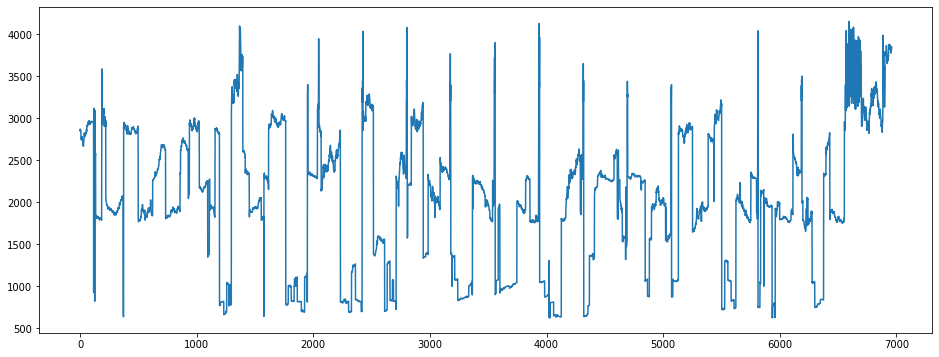

In [45]:
TRM["VALOR"].plot(figsize=(16,6))

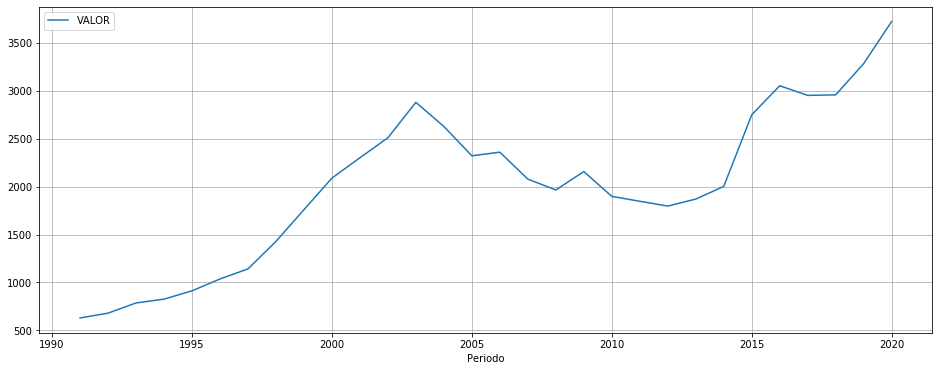

In [46]:
TRM_por_ano.plot(figsize=(16,6))
plt.grid()

# Unión de todos los datos

A continuación, se ilustra la información de una empresa promedio registrada en la SuperSociedades, bajo el código CIIU J6202.

In [47]:
variables_empresa = ["Costo de ventas","Gastos de administración","Otros gastos", "gastos totales"]
all_data = DF_consolidad.pivot_table(variables_empresa,"PERIODO", None, "sum")\
          /DF_consolidad.pivot_table(variables_empresa, "PERIODO", None, "count" )
all_data = all_data.astype(int)
all_data

,Costo de ventas,Gastos de administración,Otros gastos,gastos totales
PERIODO,,,,
2017,56891622,13114361,7325732,17516763
2018,64155146,13950594,8721194,20055813
2019,77038632,16480690,3514945,18402770


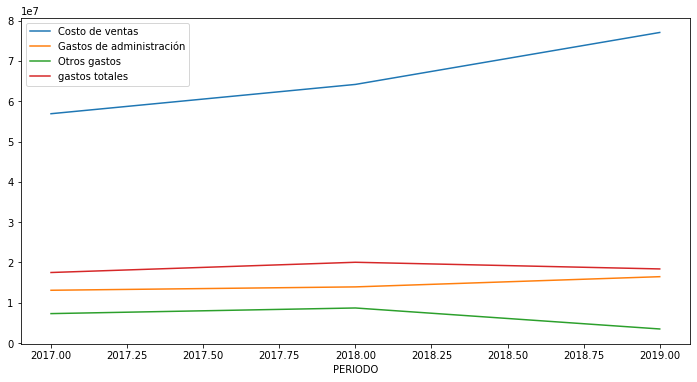

In [48]:
all_data.plot(figsize = (12,6))

Aunque la información de Costos y Gastos puede llegar a ser muy similar, como un agregado entre empresas, aquí se evidencia como los costos y los gatos, de este sector en particular, tienen comportamientos diferentes. Aunque los Costos de ventas tienen una marcada tendencia al alza, los gatos parecen más estables, e incluso, los otros gastos inician una disminución. Aun así, puede ser poca información temporal para sacar conclusiones acerca de tendencias.

A continuación, se agregan las demás variables para los años disponibles.

In [49]:
all_data.loc[:, "PIB"] = PIB.loc[range(2017,2020), "PIB_en_pesos_de_2015"]

In [50]:
all_data.loc[:, "Desmpleo"] =desempleo.loc[range(2017,2020), "TD"]

In [51]:
all_data.loc[:, "inflacion"] =inflacion.loc[range(2017,2020)]

In [52]:
all_data.loc[:, "log_costos"] =np.log(all_data["Costo de ventas"])

In [53]:
all_data.loc[:, "log_PIB"] =np.log(all_data["PIB"])

In [54]:
all_data.loc[:, "TRM"]=TRM_por_ano.loc[range(2017,2020), "VALOR"]

### Comportamiento de las variables agregadas

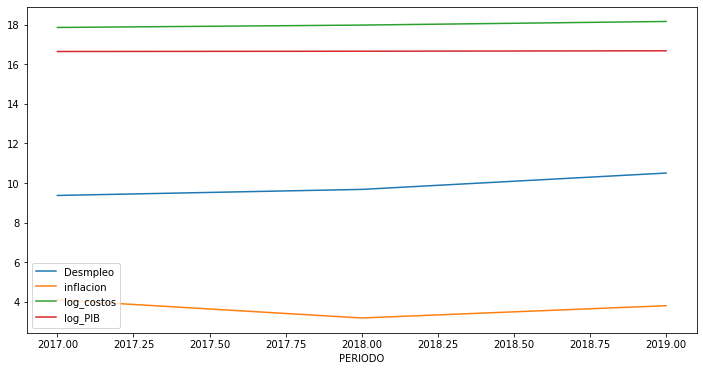

In [55]:
all_data.drop(variables_empresa+["PIB","TRM"], axis = 1).plot(figsize=(12,6))

In [56]:
all_data

,Costo de ventas,Gastos de administración,Otros gastos,gastos totales,PIB,Desmpleo,inflacion,log_costos,log_PIB,TRM
PERIODO,,,,,,,,,,
2017,56891622,13114361,7325732,17516763,16892449,9.369886,4.09,17.856659,16.642377,2950.544340
2018,64155146,13950594,8721194,20055813,17128785,9.675784,3.18,17.976815,16.656271,2956.045339
2019,77038632,16480690,3514945,18402770,17508040,10.501457,3.80,18.159818,16.678171,3282.255649


Estos son los datos que se  obtuvieron de las diferentes fuentes oficiales, procesados y extrayendo los costos y gastos para un conjunto de empresas.

# A nivel de cada empresa

La muestra seleccionada son las empresas que registraban al menos un costo de ventas en los años 2017, 2018 o 2019, para las empresas del sector. Lo cual arroja 76 empresas en total. A continuación, se hacen ajustes en la estructura de datos para poder tener la información a nivel de cada empresa (cada NIT), posteriormente se concatenan con las variables macroeconómicas previamente construidas.

In [57]:
todas_las_empresas = DF_consolidad[DF_consolidad["Costo de ventas"]>0].reset_index(drop=True)
todas_las_empresas

,NIT,Costo de ventas,Gastos de administración,Otros gastos,PERIODO,gastos totales
0,830055791,111785644.0,8687418.0,12444437.0,2017,21131855.0
1,900387076,42844825.0,8519181.0,40807.0,2017,8559988.0
2,900218578,96108899.0,30827079.0,1083.0,2017,30828162.0
3,830114969,29554834.0,5630907.0,188296.0,2017,5819203.0
4,900032774,35246124.0,7914670.0,885023.0,2017,8799693.0
...,...,...,...,...,...,...
71,830006265,1645195.0,2655185.0,3769716.0,2019,6424901.0
72,830114969,30275906.0,6405229.0,NaN,2019,6405229.0
73,900478383,174043944.0,11817410.0,993332.0,2019,12810742.0
74,830055791,92144237.0,11458156.0,167598.0,2019,11625754.0


In [58]:
variables_empresa

['Costo de ventas',
 'Gastos de administración',
 'Otros gastos',
 'gastos totales']

In [59]:
data_reg_2017 = DF_consolidad[DF_consolidad["Costo de ventas"]>0].pivot_table("Costo de ventas",
                                                                              "NIT", "PERIODO", "sum")[2017].to_frame()
data_reg_2017 = data_reg_2017.rename(columns = {2017:"Costo de ventas"})
data_reg_2017.loc[:, 'Gastos de administración'] = DF_consolidad[DF_consolidad['Costo de ventas']>0].pivot_table(
    'Gastos de administración', "NIT", "PERIODO", "sum")[2017]
data_reg_2017.loc[:, 'gastos totales'] = DF_consolidad[DF_consolidad['Costo de ventas']>0].pivot_table(
    'gastos totales', "NIT", "PERIODO", "sum")[2017]
data_reg_2017.loc[:, "PIB"] = all_data.loc[2017,"PIB"]
data_reg_2017.loc[:, "Desmpleo"] = all_data.loc[2017,"Desmpleo"]
data_reg_2017.loc[:, "inflacion"] = all_data.loc[2017,"inflacion"]
data_reg_2017.loc[:, "TRM"] = all_data.loc[2017,"TRM"]
data_reg_2017.loc[:, "t"] = 1
#data_reg_2017#.plot()

In [60]:
data_reg_2018 = DF_consolidad[DF_consolidad["Costo de ventas"]>0].pivot_table("Costo de ventas", "PERIODO", "NIT", "sum").T[2018].to_frame()
data_reg_2018 = data_reg_2018.rename(columns = {2018:"Costo de ventas"})
data_reg_2018.loc[:, 'Gastos de administración'] = DF_consolidad[DF_consolidad['Costo de ventas']>0].pivot_table(
    'Gastos de administración', "NIT", "PERIODO", "sum")[2018]
data_reg_2018.loc[:, 'gastos totales'] = DF_consolidad[DF_consolidad['Costo de ventas']>0].pivot_table(
    'gastos totales', "NIT", "PERIODO", "sum")[2018]
data_reg_2018.loc[:, "PIB"] = all_data.loc[2018,"PIB"]
data_reg_2018.loc[:, "Desmpleo"] = all_data.loc[2018,"Desmpleo"]
data_reg_2018.loc[:, "inflacion"] = all_data.loc[2018,"inflacion"]
data_reg_2018.loc[:, "TRM"] = all_data.loc[2018,"TRM"]
data_reg_2018.loc[:, "t"] = 2
#data_reg_2018

In [61]:
data_reg_2019 = DF_consolidad[DF_consolidad["Costo de ventas"]>0].pivot_table("Costo de ventas", "PERIODO", "NIT", "sum").T[2019].to_frame()
data_reg_2019 = data_reg_2019.rename(columns = {2019:"Costo de ventas"})
data_reg_2019.loc[:, 'Gastos de administración'] = DF_consolidad[DF_consolidad['Costo de ventas']>0].pivot_table(
    'Gastos de administración', "NIT", "PERIODO", "sum")[2019]
data_reg_2019.loc[:, 'gastos totales'] = DF_consolidad[DF_consolidad['Costo de ventas']>0].pivot_table(
    'gastos totales', "NIT", "PERIODO", "sum")[2019]
data_reg_2019.loc[:, "PIB"] = all_data.loc[2019,"PIB"]
data_reg_2019.loc[:, "Desmpleo"] = all_data.loc[2019,"Desmpleo"]
data_reg_2019.loc[:, "inflacion"] = all_data.loc[2019,"inflacion"]
data_reg_2019.loc[:, "TRM"] = all_data.loc[2019,"TRM"]
data_reg_2019.loc[:, "t"] = 3
#data_reg_2019

In [62]:
data_reg= data_reg_2017.append(data_reg_2018)
data_reg= data_reg.append(data_reg_2019)
#data_reg

In [63]:
data_reg.loc[:, "log_PIB"] =np.log(data_reg["PIB"])
data_reg.loc[:, "log_costos"] =np.log(data_reg["Costo de ventas"])
data_reg.loc[:, "log_TRM"] =np.log(data_reg["TRM"])
data_reg.loc[:, "log_gastos_admon"] =np.log(data_reg["Gastos de administración"])
data_reg.loc[:, "log_gastos_tot"] =np.log(data_reg["gastos totales"])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
data_reg.loc[:, "PIB_stand"] =(data_reg["PIB"] - data_reg["PIB"].mean())/data_reg["PIB"].std()
data_reg.loc[:, "costo_stand"] =(data_reg["Costo de ventas"] - data_reg["Costo de ventas"].mean())/data_reg["Costo de ventas"].std()
data_reg.loc[:, "gastos_stand"] =(data_reg["Gastos de administración"] - data_reg["Gastos de administración"].mean())/data_reg["Gastos de administración"].std()
#data_reg.loc[:, "PIB_stand"] =(data_reg["PIB"] - data_reg["PIB"].mean())/data_reg["PIB"].std()

In [65]:
data_reg.loc[:,"const"] = 1

Para el modelo fue necesario transformar las variables de costos y gastos de la empresa, debido a que están en millones de pesos, lo que los hace estar en escalas muy diferentes a los datos macroeconómicos. Es por este motivo que se hacen 2 tipos de transformaciones que permitan tener una variable de interés que pueda ser mejor relacionada con las variables explicativas. Las transformaciones realizadas fueron: el cálculo del logaritmo natural y la estandarización de escalado (restar la media y dividir la desviación estándar).

La Base de datos final a nivel de empresa que se utilizó para ajustar los diferentes modelos de regresión lineal es la siguiente:

In [66]:
data_reg

,Costo de ventas,Gastos de administración,gastos totales,PIB,Desmpleo,inflacion,TRM,t,log_PIB,log_costos,log_TRM,log_gastos_admon,log_gastos_tot,PIB_stand,costo_stand,gastos_stand,const
NIT,,,,,,,,,,,,,,,,,
800057965,110767124.0,31548735.0,34744486.0,16892449,9.369886,4.09,2950.544340,1,16.642377,18.522941,7.989745,17.267044,17.363531,-1.114277,0.553175,1.284991,1
800103052,311768330.0,13654669.0,28446731.0,16892449,9.369886,4.09,2950.544340,1,16.642377,19.557771,7.989745,16.429592,17.163544,-1.114277,3.016069,0.161059,1
800159527,20223401.0,11366116.0,12799779.0,16892449,9.369886,4.09,2950.544340,1,16.642377,16.822351,7.989745,16.246147,16.364938,-1.114277,-0.556269,0.017314,1
800241958,174589422.0,56224624.0,59132951.0,16892449,9.369886,4.09,2950.544340,1,16.642377,18.977948,7.989745,17.844865,17.895299,-1.114277,1.335198,2.834892,1
805025216,1526861.0,227974.0,257530.0,16892449,9.369886,4.09,2950.544340,1,16.642377,14.238725,7.989745,12.336987,12.458891,-1.114277,-0.785360,-0.682277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900555829,6126781.0,520693.0,617315.0,17508040,10.501457,3.80,3282.255649,3,16.678171,15.628180,8.096286,13.162916,13.333135,1.301208,-0.728997,-0.663891,1
900583745,NaN,NaN,NaN,17508040,10.501457,3.80,3282.255649,3,16.678171,NaN,8.096286,NaN,NaN,1.301208,NaN,NaN,1
900601546,23519117.0,2239913.0,2315460.0,17508040,10.501457,3.80,3282.255649,3,16.678171,16.973324,8.096286,14.621948,14.655119,1.301208,-0.515886,-0.555906,1


### División de la base de datos en entrenamiento y pruebas

Un total del 76 empresas, de las cuales usaremos un conjunto de estos para ajustar los modelos y el otro para evaluar los resultados en un conjunto que nunca haya estudiado. Para las divisiones de la base de datos, se utilizaran unos porcentages de 80-20, 80% para entrenamiento o ajuste del modelo, y un 20% para la evaluación del desempeño.

In [67]:
#todas_las_empresas.NIT.unique()[np.random.randint(0,len(todas_las_empresas.NIT.unique()), round(len(todas_las_empresas.NIT.unique())*.8) )]

In [68]:
index_train = todas_las_empresas.NIT.unique()[:round(len(todas_las_empresas.NIT.unique())*.8)]
index_test = todas_las_empresas.NIT.unique()[round(len(todas_las_empresas.NIT.unique())*.8):]
#index_train = np.random.randint(0,len(todas_las_empresas.NIT.unique()), round(len(todas_las_empresas.NIT.unique())*.8) )
#index_test = np.random.randint(0,len(todas_las_empresas.NIT.unique()), round(len(todas_las_empresas.NIT.unique())*.2) )

In [69]:
(len(todas_las_empresas.set_index("NIT").loc[index_train]), len(todas_las_empresas.set_index("NIT").loc[index_test]),
 len(todas_las_empresas))

(66, 10, 76)

In [70]:
print("NITs para entrenar:", index_train)

NITs para entrenar: [830055791 900387076 900218578 830114969 900032774 900478383 900150662
 830006265 800057965 800103052 800241958 900601546 830089336 830103650
 830042244 900583745 800159527 830110433 900210032 860002433 900079131
 900555829 900478030 900258336 805025216 900420814]


In [71]:
print("NITs para probar el desempeño:", index_test)

NITs para probar el desempeño: [900091709 830135305 900773345 900129331 900103457 900912034 900266595]


In [72]:
data_reg_train= data_reg.loc[index_train].reset_index().drop("NIT", axis=1)

In [73]:
data_reg_test= data_reg.loc[index_test].reset_index().drop("NIT", axis=1)

### Costos de ventas para cada una de las empresas en escala logaritmica

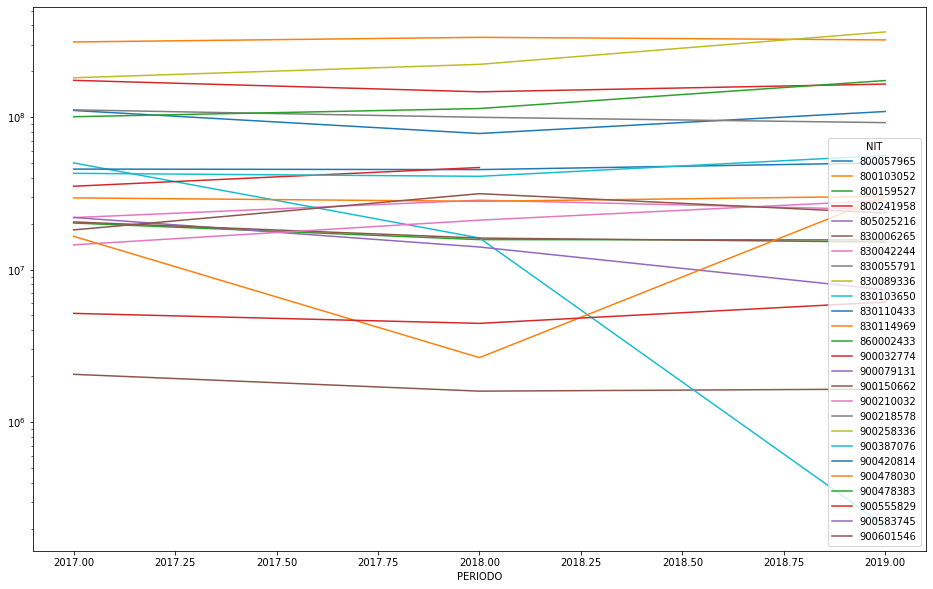

In [74]:
todas_las_empresas.set_index("NIT").loc[index_train].pivot_table("Costo de ventas", "PERIODO", "NIT", "sum").plot(
    figsize=(16,10), )#fillna(0)#[800110980]
plt.yscale('log')

### Distribución de variables a utilizar en modelos de regresión

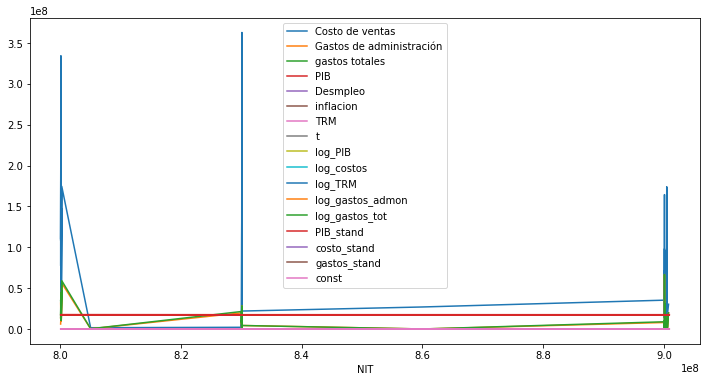

In [75]:
data_reg.plot(figsize = (12,6))

Se evidencia la falta de variabilidad de las variables macroeconomicas, debido a que como se organizan y se modelan los datos, se tienen más de 70 observaciones para las variables de las empresas, pero solo 3 valores para las variables macroeconomicas.

In [76]:
data_reg["log_costos"].describe()

count    76.000000
mean     17.236920
std       1.430035
min      12.243166
25%      16.595929
50%      17.225807
75%      18.384564
max      19.709658
Name: log_costos, dtype: float64

Como se evidencia, la variable a explicar tiene una media de 17,23, con una desviación estandar de 1.4, lo cual nos muestra una buena variabilidad. Tambien los cuartiles, el mínimo y el máximo, los valores se mueven en general entre 16 y 19, con algunos valores atipicos.

In [77]:
data_reg2 = data_reg.drop(data_reg[data_reg["Costo de ventas"].isna()].index.unique())

# Resultados

Se utiliza un modelo de regresión lineal para modelar la relación entre las variables PIB, Inflación, Desempleo, Tasa
de Cambio-TRM y los costos de ventas y los gastos de administración. 
Se probaron diferentes modelos, iniciando con un modelo que contenia todas las variables explicativas construidas. 
El modelo que contenia todas las variables explicativas, no obtuvo un buen desempeño, por lo que se probaron diferentes alternativas, entre las que estan modeos con menos variables, y probar combinaciones con algunas de las transformaciones de las variables. 
Se fueron probando modelos a los que se les fueron eliminando variables paulatinamente, eliminando una variable de las que tengan un P-valor más alto a la vez, estimando de nuevo el modeo con las variables restantes y eliminando una variable de nuevo. A continuación se reportan algunos de estos modelos, el que contiene todas las variables y dos que tuvieron unos resultados razonables.

$\text{Costos_de_ventas} = \beta_0 + \beta_1*\text{Desempleo} +\beta_2*PIB+\beta_3*TRM +\beta_4*\text{inflación} + \beta_5*\text{Gastos_de_administración}+\beta_6*TRM + E_i$

In [78]:
reg = sm.OLS(endog=data_reg2.sort_index()["Costo de ventas"],
             exog=data_reg2.sort_index()[["const", "Desmpleo", 'log_TRM', "inflacion", "Gastos de administración", "t", 'PIB']],
             missing='drop')
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Costo de ventas   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     6.056
Date:                Sun, 29 Nov 2020   Prob (F-statistic):            0.00121
Time:                        20:28:06   Log-Likelihood:                -1174.0
No. Observations:                  60   AIC:                             2356.
Df Residuals:                      56   BIC:                             2364.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

$\text{Costos_de_ventas} =  \beta_0*\text{Gastos_de_administración} +\beta_1*PIB+\beta_2*TRM + E_i$

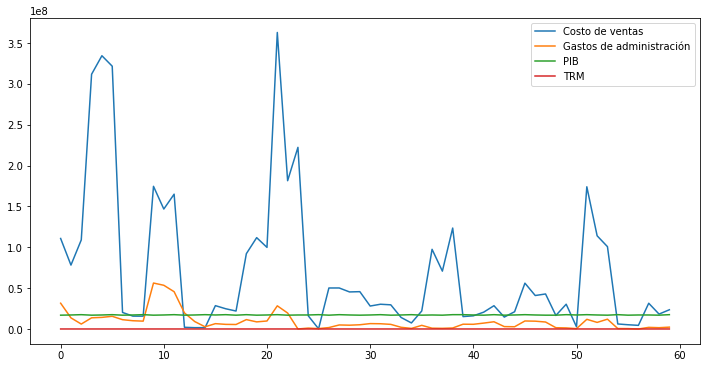

In [79]:
data_reg2[["Costo de ventas", 'Gastos de administración', 'PIB', "TRM"]].sort_index().reset_index(drop=True).plot(
    figsize=(12,6))

In [80]:
reg = sm.OLS(endog=data_reg2.sort_index()["Costo de ventas"],
             exog=data_reg2.sort_index()[['Gastos de administración', 'PIB', "TRM"]],
             missing='drop')
results = reg.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        Costo de ventas   R-squared (uncentered):                   0.552
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              23.41
Date:                Sun, 29 Nov 2020   Prob (F-statistic):                    5.31e-10
Time:                        20:28:06   Log-Likelihood:                         -1174.1
No. Observations:                  60   AIC:                                      2354.
Df Residuals:                      57   BIC:                                      2360.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

$\text{Costos_de_ventas} =  \beta_0*\text{Desempleo} + \beta_1*\text{inflacion} + E_i$

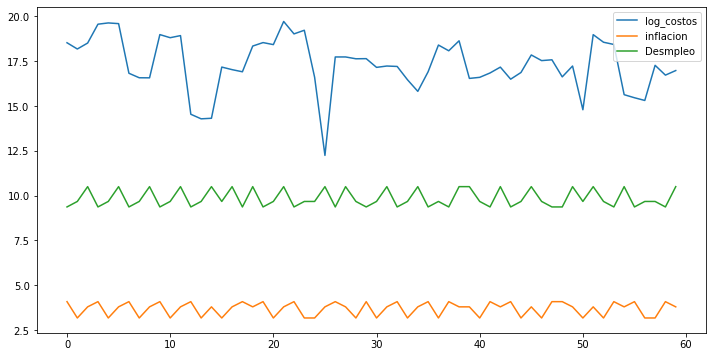

In [81]:
data_reg2[["log_costos", "inflacion", "Desmpleo"]].sort_index().reset_index(drop=True).plot(figsize=(12,6))

In [82]:
reg = sm.OLS(endog=data_reg2["Costo de ventas"],
             exog=data_reg2[["Desmpleo", "inflacion"]],
             missing='drop')
results = reg.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        Costo de ventas   R-squared (uncentered):                   0.411
Model:                            OLS   Adj. R-squared (uncentered):              0.391
Method:                 Least Squares   F-statistic:                              20.26
Date:                Sun, 29 Nov 2020   Prob (F-statistic):                    2.13e-07
Time:                        20:28:07   Log-Likelihood:                         -1182.3
No. Observations:                  60   AIC:                                      2369.
Df Residuals:                      58   BIC:                                      2373.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

El modelo lineal que mejores resultados obtuvo usando las variables macroeconómicas disponibles es: 

$\text{Costos_de_ventas} =  \beta_0*\text{Gastos_de_administración} +\beta_1*PIB+\beta_2*TRM + E_i$

Este modelo usa como variable dependiente los $\text{Costos_de_ventas}$ de las empresas, y como variables regresoras: los $\text{Gastos_de_administración}$ de las empresas, el Producto Interno Bruto $PIB$ y la Tasa de Cambio Representativa del Mercado TRM.

In [83]:
Y = "Costo de ventas"
XS = ['Gastos de administración', 'PIB', "TRM"]

In [84]:
reg = sm.OLS(endog=data_reg2.sort_index()[Y],
             exog=data_reg2.sort_index()[XS],#, "PIB_stand", ],
             missing='drop')
results = reg.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        Costo de ventas   R-squared (uncentered):                   0.552
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              23.41
Date:                Sun, 29 Nov 2020   Prob (F-statistic):                    5.31e-10
Time:                        20:28:07   Log-Likelihood:                         -1174.1
No. Observations:                  60   AIC:                                      2354.
Df Residuals:                      57   BIC:                                      2360.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

Como se puede evidenciar en la tabla de resultados de la regresión, el modelo en general tiene un buen ajuste, ya que da un $R^2$ y un $R^2_{Adj}$ de 0.552 y 0.528, respectivamente. Adicionalmente, aunque no todos los P-valores asignados a la prueba de hipótesis de que cada regresor tenga un efecto nulo en la variable explicativa, no son muy cercanos a cero, son los mejores que se lograron obtener, dados los datos. Se rechaza contundentemente la hipótesis de que los Gastos de administración tienen un efecto nulo en los costos de ventas, evidenciando un efecto significativo del Gastos de administración de las empresas en los Costos de ventas de las empresas de este sector. De forma similar, el P-valor asignado a la prueba de hipótesis de que conjuntamente todos los regresores tengan un efecto nulo en la variable explicativa, también es muy cercana a cero por lo que también se rechaza esta hipótesis.

De este modelo podemos concluir que en general los Gastos de administración y la TRM tienen efectos positivos considerables sobre los costos de ventas en el sector económico elegido, mientras que el PIB tiene un efecto negativo sobre los costos de ventas.

## Evaluación del ajuste y la capacidad predictiva

Como vimos anteriormente, los resultados sobre el conjunto de entrenamiento son satisfactorios, debido a que se obtuvo un $R^2$ y un $R^2_{Adj}$ de 0.552 y 0.528, lo cual habla en general de un buen ajuste.

Para evaluar el ajuste, se utiliza el conjunto de pruebas de las divisiones que se habían realizado previamente y se realizan predicciones sobre este conjunto de datos con los que nunca se ha entrenado. Para estas predicciones se calculan las métricas del Error cuadrático Medio y de Raíz del Error cuadrático Medio (o MSE y RMSE por sus siglas en ingles). 

In [85]:
#Y_H = results.params[0]*data_reg_test[XS[0]]+results.params[1]*data_reg_test[XS[1]]+results.params[2]*data_reg_test[XS[2]]
Y_H = (results.params*data_reg_test[XS]).sum(axis=1)
# Y_H

In [86]:
data_reg_test.loc[:,"Y_hat"] = Y_H
# data_reg_test

In [87]:
MSE = round(((Y_H - data_reg_test[Y]) ** 2).mean(), 4)
MSE, sqrt(MSE)

(5078509316661934.0, 71263660.5617613)

### Gráfica de Predicción Vs Real en conjunto de Pruebas

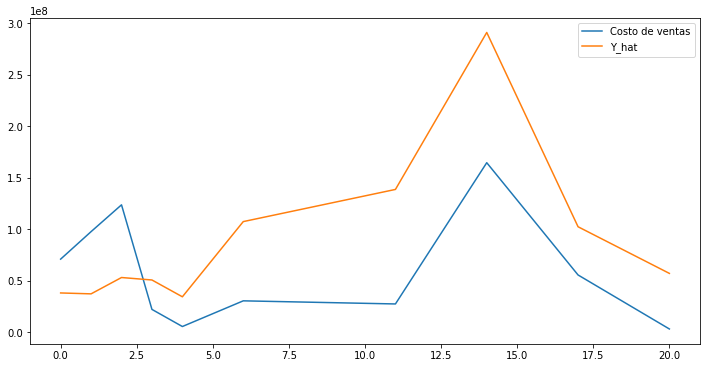

In [88]:
data_reg_test[data_reg_test[Y].notna()][[Y, "Y_hat"]].plot(figsize= (12,6))#.scatter(x = "log_costos", y = i)

Las gráficas con los resultados se ven muy coherentes, así como los resultados de los modelos.

# Conclusiones

- En general los Gastos de administración y la TRM tienen efectos positivos considerables sobre los costos de ventas en el sector económico elegido, mientras que el PIB tiene un efecto negativo sobre los costos de ventas en el sector económico J6202 "Actividades de consultoría informática y actividades de administración de instalaciones informáticas".


- Es difícil acceder de manera normal a algunos de la información macroeconómica de referencia para el país, por ejemplo, las páginas web de la SuperSociedades y el Banco de la Republica tienen muchos enlaces caídos. Se rescata la iniciativa del gobierno nacional donde centralice toda la información oficial y libre para el uso de todos los ciudadanos.

# Estimación del esfuerzo de las actividades

1) Consolidación de información: Grande, mucho tiempo perdido buscando bases de datos (12horas)

2) Transformación de varibles y análisis descriptivo: mediano, algunas de las bases de datos tenian formatos muy complicados (5 horas)

3) Ajuste y validación de modelos: grande, fue díficil encontrar una relacion de variables que pudiera tener sentido económico y buenos resultados estadísticos (10 horas).

4) Redacción del reporte: mediano, es maluco realizar revisiones de forma y sobre un jupyter, pues no tiene incorporado un corrector de ortografía (5 horas).